In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import statsmodels.api as sm

%matplotlib inline

# Load Data

In [2]:
# df = pd.read_csv('../data/airborne_data.csv', parse_dates=['timestamp'], index_col='timestamp')
# df = pd.read_csv('../../data/airborne_data_20241015.csv', parse_dates=['timestamp'], index_col='timestamp')
df = pd.read_csv('../../data/processed/complete_data.csv', parse_dates=['timestamp'], index_col='timestamp')

/tmp/ipykernel_959603/1611110707.py:3: DtypeWarning: Columns (195) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../data/processed/complete_data.csv', parse_dates=['timestamp'], index_col='timestamp')


# Analysis

In [3]:
def rma_regression_slope(df, x, y):
    slope_a = sm.OLS(df[y], df[x], missing='drop').fit().params[0]
    slope_b = sm.OLS(df[x], df[y], missing='drop').fit().params[0]
    
    slope_b = 1 / slope_b
    # Check if correlated in same direction
    if np.sign(slope_a) != np.sign(slope_b):
        raise RuntimeError('Type I regressions of opposite sign.')
    
    # Compute Reduced Major Axis Slope
    slope = np.sign(slope_a) * np.sqrt(slope_a * slope_b)
    
    # Compute r
    r = np.sign(slope_a) * np.sqrt(slope_a / slope_b)
    
    return slope, r**2

# Plot

### Figure 4

In [4]:
near_field = df[df['age']<20]

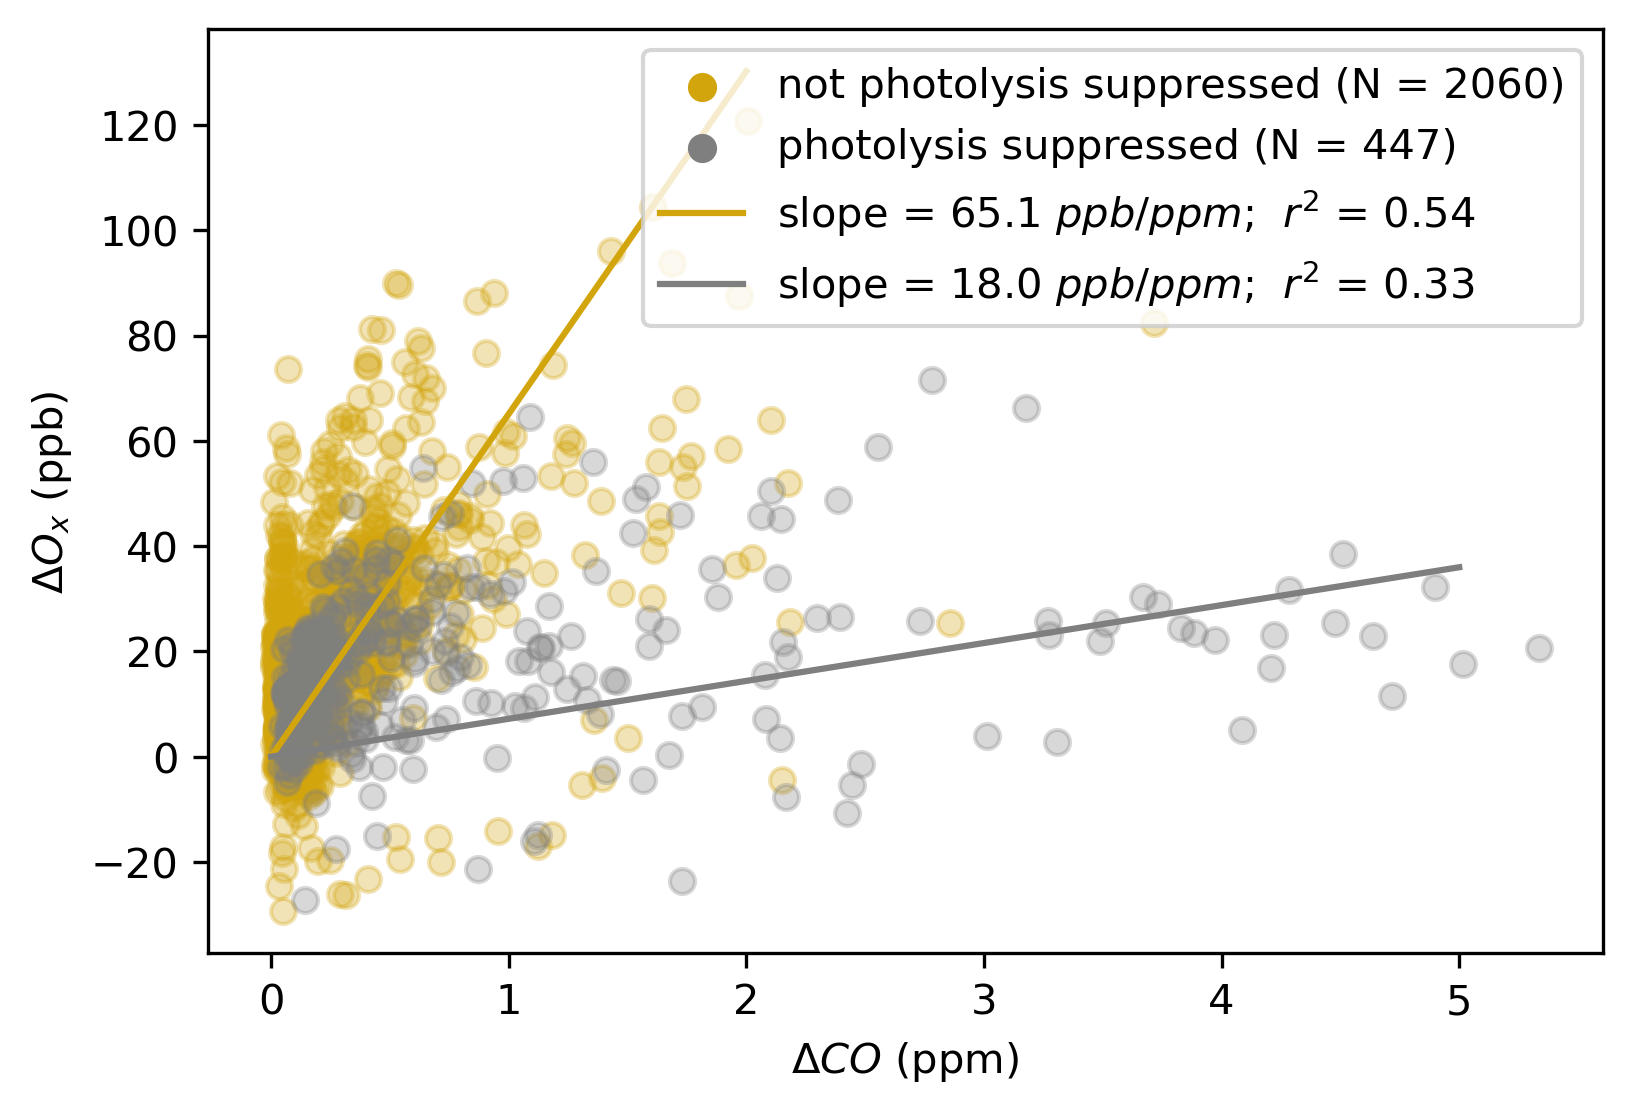

In [6]:
fig,ax = plt.subplots(figsize=(6,4), dpi=300)

tmp_suppressed = near_field[(near_field['jNO2']<0.005)&(near_field['OA_AMS']>20)]
tmp_notsuppressed = near_field[(near_field['jNO2']>0.005)|((near_field['jNO2']<0.005)&(near_field['OA_AMS']<20))]

p = ax.scatter(tmp_notsuppressed['CO_delta']/1e6, tmp_notsuppressed['Ox_delta']/1000, alpha=0.3, label='not photolysis suppressed (N = {})'.format(len(tmp_notsuppressed)), color='#D3A50D')# c=near_field['jNO2'], vmin=0.001,vmax=1.1e-2)
p = ax.scatter(tmp_suppressed['CO_delta']/1e6, tmp_suppressed['Ox_delta']/1000, alpha=0.3, label='photolysis suppressed (N = {})'.format(len(tmp_suppressed)), color='tab:grey')# c=near_field['jNO2'], vmin=0.001,vmax=1.1e-2)
slope, r2 = rma_regression_slope(tmp_notsuppressed, 'CO_delta', 'Ox_delta')
ax.plot(np.linspace(0,2,100), slope*np.linspace(0,2000,100), label=r'slope = {} $ppb/ppm$;  $r^2$ = {}'.format(round(slope*1e3, 1), round(r2, 2)), color='#D3A50D')
slope, r2 = rma_regression_slope(tmp_suppressed, 'CO_delta', 'Ox_delta')
ax.plot(np.linspace(0,5,100), slope*np.linspace(0,2000,100), label=r'slope = {} $ppb/ppm$;  $r^2$ = {}'.format(round(slope*1e3, 1), round(r2, 2)), color='tab:grey')


ax.set_xlabel(r'$\Delta CO$ (ppm)',)
ax.set_ylabel(r'$\Delta O_x$ (ppb)')

# ax.set_title(r'Near Field Points (age < 20 hrs)'.format(len(near_field)),)

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major',)
ax.tick_params(axis='both', which='minor',)

leg = ax.legend(loc='upper right',)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
#save figure as pdf
plt.savefig("../../figures/fig_04.pdf", bbox_inches='tight', dpi=300)